In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Load a curated set of so-called clean conflicts, which excludes all conflicts which seem to be duplicates or to be caused by known bugs.

In [4]:
conflicts = spark.read.parquet("/tmp/awight/clean_conflicts").cache()
conflicts.count()

1939

Where are conflicts happening?  On all wikis?

TODO:
* namespace pie
* scatterplot of wiki edit activity x rate of conflicts.  dot size is ~ wiki size

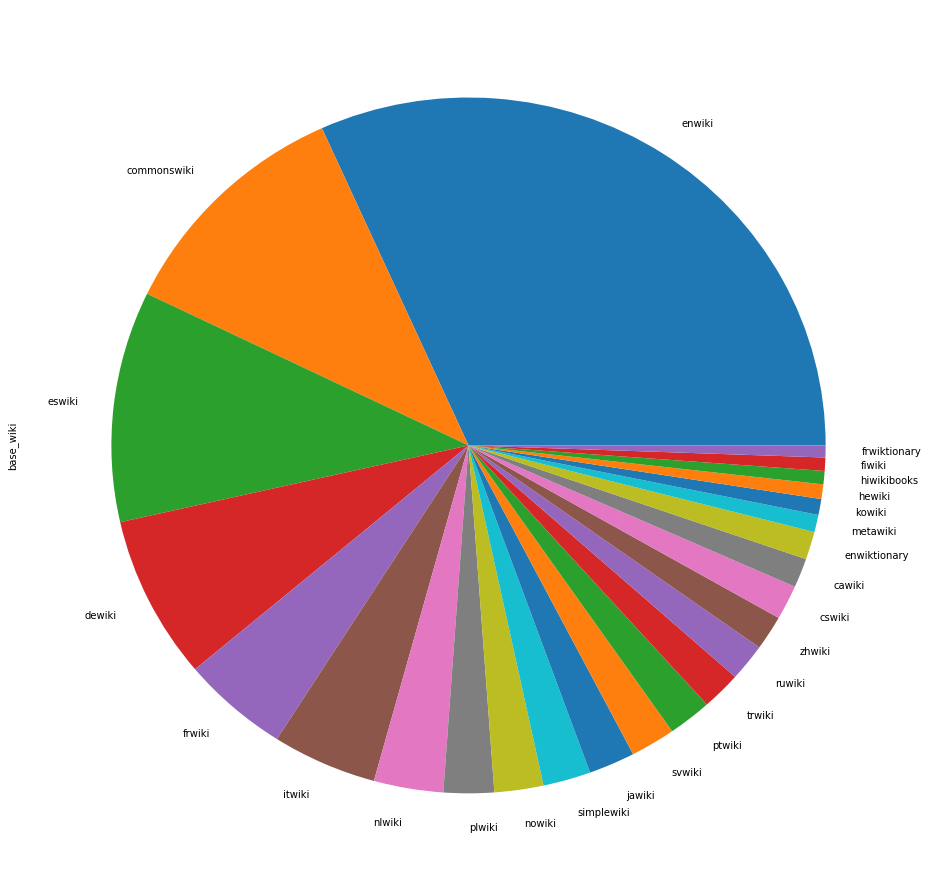

In [5]:
c = conflicts.toPandas()
c['base_wiki'].value_counts()[0:25].plot.pie(figsize=(16,16))

Are conflicting edits usually close together in time?  Is the page being editing very actively, in which case the base and other revisions would be very recent?  Is the base revision old, and the other and conflicting edits are close together?

TODO:
* Gather "starttime" metrics to see how long the editor spent on the edit page.
* Plot relative age as a distribution

In [6]:
ages = pd.DataFrame(
    data={
        'base_age': (c['conflict_timestamp'] - c['base_timestamp']) / pd.Timedelta(1, unit='s'),
        'other_age': (c['conflict_timestamp'] - c['other_timestamp']) / pd.Timedelta(1, unit='s')
    }
)

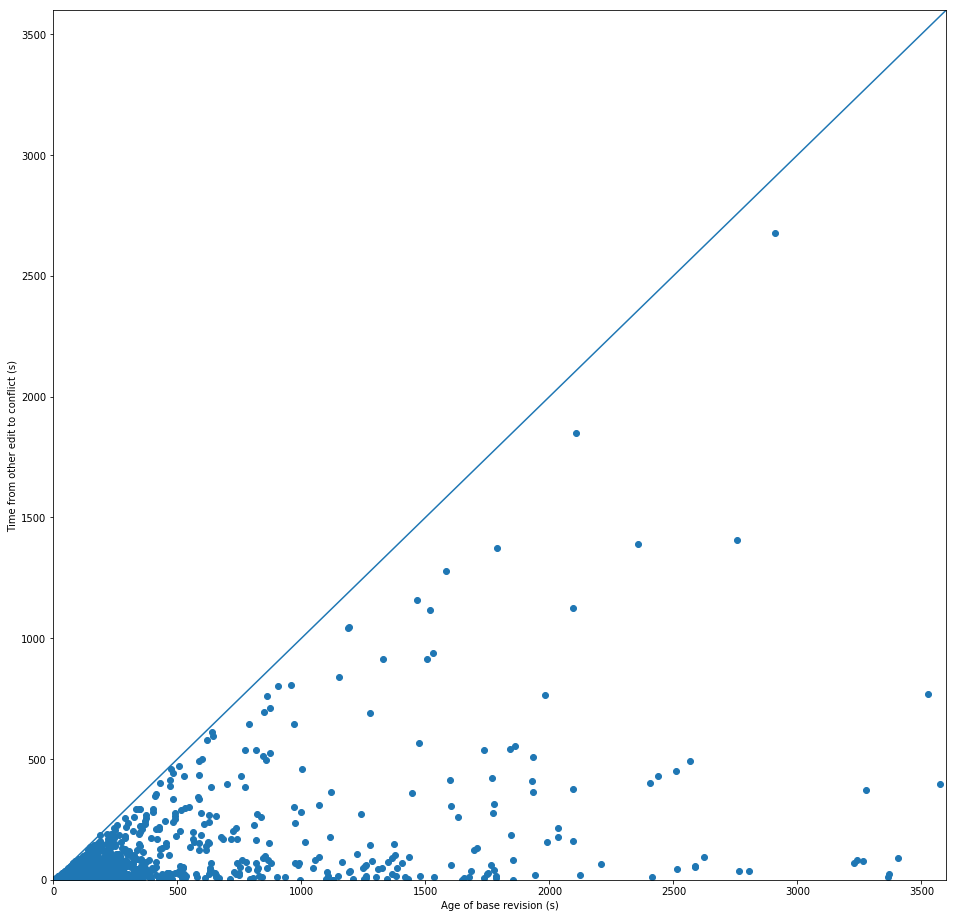

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 16)
ax.scatter(ages.base_age, ages.other_age)
ax.plot([0, 3600], [0, 3600])
ax.set_xlim(0, 3600)
ax.set_ylim(0, 3600)
ax.set_xlabel('Age of base revision (s)')
ax.set_ylabel('Time from other edit to conflict (s)')
plt.show()

In [8]:
relative_ages = pd.Series(
    data=ages.other_age / ages.base_age
).dropna()

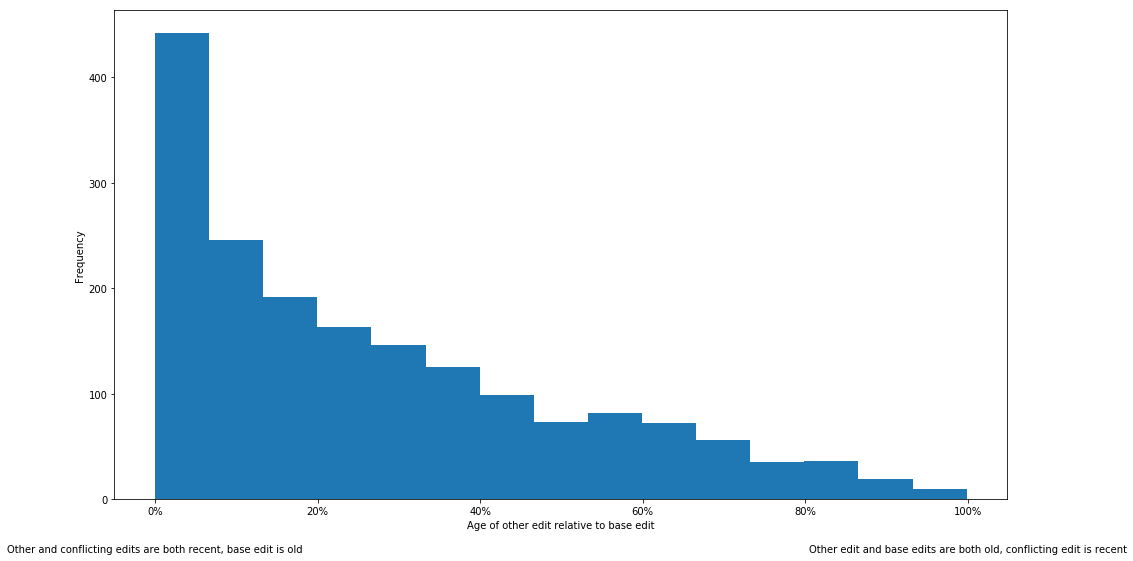

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 9)
ax.hist(relative_ages, 15)
ax.set_xlabel('Age of other edit relative to base edit')
ax.set_ylabel('Frequency')
ax.text(0, -50, 'Other and conflicting edits are both recent, base edit is old', ha='center')
ax.text(1, -50, 'Other edit and base edits are both old, conflicting edit is recent', ha='center')
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.show()

## Double conflicts

How often do conflicts pile up due to rapid editing?  In other words, is it common to experience a second edit conflict when trying to save the results of resolving the first?

In this case, the baseRevisionId of one conflict would be the latestRevisionId of a previous conflict.  Searching for those is a good start.

In [16]:
from pyspark.sql.functions import col

double_conflicts = conflicts.alias("first_conflict").join(
    conflicts.alias("second_conflict"),
    (col("first_conflict.wiki") == col("second_conflict.wiki"))
        & (col("first_conflict.latestRevisionId") == col("second_conflict.baseRevisionId"))
        # FIXME: Only slightly better than nothing to correlate the user...
        & (col("first_conflict.browser_family") == col("second_conflict.browser_family"))
)

double_conflicts.count()

110

So, what are these?

In [26]:
double_conflicts.groupBy(["first_conflict.wiki", "first_conflict.page_title"]).count().sort("count", ascending=False).show(n=20, truncate=False)

+------------+-------------------------------------------------------------+-----+
|wiki        |page_title                                                   |count|
+------------+-------------------------------------------------------------+-----+
|enwiki      |User:M.hin.ck/sandbox                                        |15   |
|enwiki      |User_talk:King_Mythical_Tiger                                |8    |
|eswiki      |Usuario_discusión:80.32.15.88                                |7    |
|enwiktionary|Gilgameshian                                                 |4    |
|ltwiki      |Bušmėnai                                                     |3    |
|nowiki      |Steinalderen                                                 |3    |
|enwiki      |Wikipedia:Edit_filter/False_positives/Reports                |3    |
|simplewiki  |User_talk:80.194.200.53                                      |3    |
|enwiki      |Ezra_Furman_and_the_Harpoons                                 |2    |
|sqw

Play with a transformation to display each diff composing a conflict.  However, the "your text" is missing from this, making it less useful than I'd hoped.

In [82]:
from pyspark.sql.functions import concat, lit

def makeDiffAnchor(title, rev_id_column, parent_rev_id_column=None):
    global conflicts
    terms = [
        lit("<a href=\"https://"),
        conflicts.webhost,
        lit("/wiki/?diff="),
        rev_id_column
    ]
    if parent_rev_id_column is not None:
        terms.extend([
            lit("&oldid="),
            parent_rev_id_column
        ])
    terms.extend([lit("\">{}</a>".format(title))])
    return concat(*terms)


diff_links = conflicts.select(
    makeDiffAnchor("->B", conflicts.baseRevisionId).alias("base_diff"),
    makeDiffAnchor("B->O", conflicts.other_rev_id, conflicts.baseRevisionId).alias("other_base_diff"),
    makeDiffAnchor("O->N", conflicts.next_rev_id, conflicts.other_rev_id).alias("other_next_diff"),
)

from IPython.display import HTML
pd.set_option('display.max_colwidth', -1)
HTML(diff_links.toPandas().head(10).to_html(escape=False))

,base_diff,other_base_diff,other_next_diff
0,->B,B->O,O->N
1,->B,B->O,O->N
2,->B,B->O,O->N
3,->B,B->O,O->N
4,->B,B->O,O->N
5,->B,B->O,O->N
6,->B,B->O,O->N
7,->B,B->O,O->N
8,->B,B->O,None
9,->B,B->O,O->N
